# main code

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt


In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## load dataset

In [5]:
data_dir = "original_data_set"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
class_names


Found 1512 files belonging to 6 classes.
Using 1210 files for training.
Found 1512 files belonging to 6 classes.
Using 302 files for validation.


['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

## display sample images 

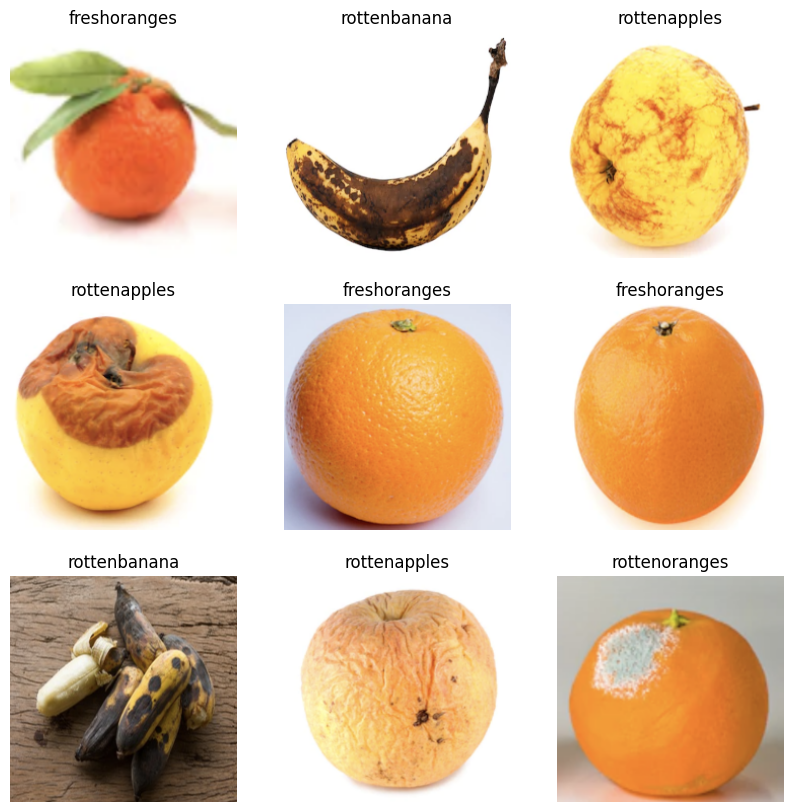

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### prefetch

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


### build model

In [ ]:
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False   # Freeze pretrained weights
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(len(class_names), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 4057257 (15.48 MB)
Trainable params: 7686 (30.02 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


### train model

In [10]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10


38/38 [==============================] - 34s 720ms/step - loss: 0.8744 - accuracy: 0.7471 - val_loss: 0.3911 - val_accuracy: 0.9139
Epoch 2/10
38/38 [==============================] - 26s 668ms/step - loss: 0.2699 - accuracy: 0.9562 - val_loss: 0.2412 - val_accuracy: 0.9272
Epoch 3/10
38/38 [==============================] - 24s 623ms/step - loss: 0.1740 - accuracy: 0.9686 - val_loss: 0.1917 - val_accuracy: 0.9536
Epoch 4/10
38/38 [==============================] - 26s 662ms/step - loss: 0.1364 - accuracy: 0.9802 - val_loss: 0.1634 - val_accuracy: 0.9404
Epoch 5/10
38/38 [==============================] - 25s 653ms/step - loss: 0.1169 - accuracy: 0.9752 - val_loss: 0.1421 - val_accuracy: 0.9570
Epoch 6/10
38/38 [==============================] - 26s 673ms/step - loss: 0.0997 - accuracy: 0.9826 - val_loss: 0.1291 - val_accuracy: 0.9536
Epoch 7/10
38/38 [==============================] - 25s 650ms/step - loss: 0.0872 - accuracy: 0.9851 - val_loss: 0.1205 - val_accuracy: 0.95

### plot accuracy and loss

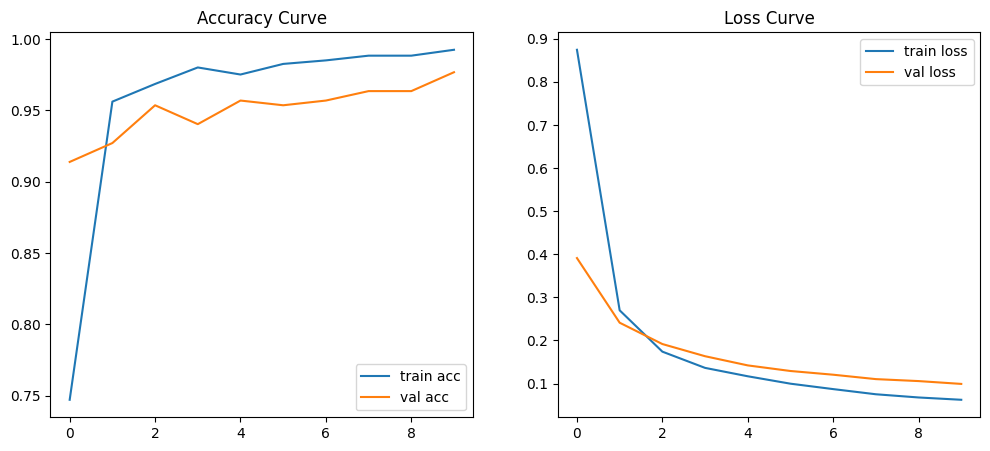

In [11]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Accuracy Curve")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Loss Curve")
plt.legend()

plt.show()


### save model

In [12]:
os.makedirs("models", exist_ok=True)
model.save("models/efficientnet_fruit.h5")
print("Model saved!")


c:\Users\KIIT0001\Documents\Mini Project\fruit-freshness-ditection\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved!


### prediction of image

1/1 [==============================] - 0s 80ms/step
Prediction: freshbanana


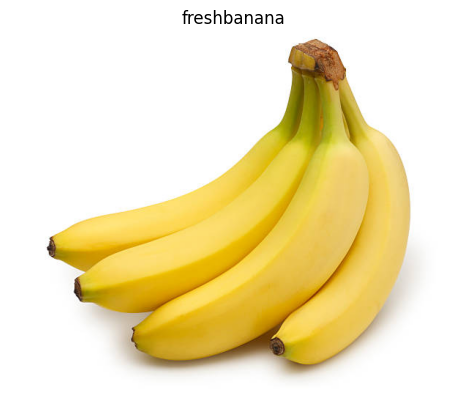

In [15]:
test_path = "test-image/test-pic-fresh-banana.jpg"

img = load_img(test_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

print("Prediction:", predicted_class)

plt.imshow(load_img(test_path))
plt.title(predicted_class)
plt.axis("off")
plt.show()
